# Feature Engineering

In [92]:
import os
import glob
import librosa
import soundfile as sf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display


def normalize_audio(y, target_db_level):
    """Normalize audio to a target decibel (dB) level for uniform loudness."""
    rms = librosa.feature.rms(y=y)[0]
    current_db = librosa.amplitude_to_db(rms, ref=np.max)
    db_adjustment = target_db_level - np.mean(current_db)
    return y * (10 ** (db_adjustment / 20))

def apply_gain(y, gain_range=(13, 17)):
    """Randomly amplify the audio signal within a specified dB range to vary audio intensity."""
    gain_db = np.random.uniform(*gain_range)
    return y * (10 ** (gain_db / 20))

def add_gaussian_noise(y, noise_level=0.005):
    """Add Gaussian noise to simulate background noise conditions."""
    noise = np.random.normal(0, noise_level, y.shape)
    return y + noise

def process_audio_file_with_denoising(audio_path):
    """Load, resample if needed, denoise, and normalize the audio."""
    y, sr = librosa.load(audio_path, sr=None)
    
    if sr != SAMPLE_RATE:
        y = librosa.resample(y, orig_sr=sr, target_sr=SAMPLE_RATE)

    # Trim silence from start and end
    y, _ = librosa.effects.trim(y, top_db=20)

    # Apply spectral gating for denoising
    y = spectral_gating(y, SAMPLE_RATE)

    # Normalize to a target dB level
    y = normalize_audio(y, TARGET_DB_LEVEL)

    # Trim or pad to segment length
    segment_length = SEGMENT_DURATION * SAMPLE_RATE
    if len(y) < segment_length:
        y = np.tile(y, int(np.ceil(segment_length / len(y))))[:segment_length]
    else:
        y = y[:segment_length]
    
    return y
    
def spectral_gating(y, sr, threshold_ratio=1.2, apply_denoising=True):
    """Applies spectral gating to reduce background noise."""
    if not apply_denoising:
        return y  
    
    stft = librosa.stft(y)
    magnitude, phase = np.abs(stft), np.angle(stft)
    noise_magnitude = np.median(magnitude, axis=1).reshape((-1, 1))
    mask = magnitude >= (noise_magnitude * threshold_ratio)
    denoised_stft = mask * magnitude * np.exp(1j * phase)
    return librosa.istft(denoised_stft)
    
def create_log_mel_spectrogram(y, sr):
    """Generate a Log-Mel Spectrogram from the audio signal."""
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    return librosa.power_to_db(mel_spec, ref=np.max)
    

def apply_spectrogram_augmentation(S_db):
    """
    Apply milder augmentations to the Mel-spectrogram to prevent large blank areas.
    """

    time_mask = np.random.randint(50, 100)  # Random width between 300 and 500
    t0 = np.random.randint(0, max(S_db.shape[1] - time_mask, 1))

    freq_mask = np.random.randint(1, 7)  # Adjust as desired for frequency masking width
    f0 = np.random.randint(0, max(S_db.shape[0] - freq_mask, 1))

    S_db[:, t0:t0 + time_mask] = 0
    S_db[f0:f0 + freq_mask, :] = 0
    
    return S_db

def save_log_mel_spectrogram(S_db, output_path):
    """Save the Log-Mel spectrogram as a numpy array file."""
    np.save(output_path, S_db)


def create_mfcc(y, sr, n_mfcc=13):
    """Generate MFCCs from the audio signal."""
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    return np.vstack([mfcc, mfcc_delta, mfcc_delta2])

def create_chroma(y, sr):
    """Generate Chroma feature from the audio signal."""
    return librosa.feature.chroma_stft(y=y, sr=sr, n_fft=2048, hop_length=512)

def create_tonnetz(y, sr):
    """Generate Tonnetz feature from the audio signal."""
    harmonic = librosa.effects.harmonic(y)
    return librosa.feature.tonnetz(y=harmonic, sr=sr)

def create_combined_features(y, sr, n_mfcc=13):
    """Generate and concatenate MFCC, chroma, and tonnetz features."""
    mfcc_features = create_mfcc(y, sr, n_mfcc)
    chroma_features = create_chroma(y, sr)
    tonnetz_features = create_tonnetz(y, sr)
    
    # Normalize and concatenate features
    mfcc_features = (mfcc_features - np.mean(mfcc_features)) / np.std(mfcc_features)
    chroma_features = (chroma_features - np.mean(chroma_features)) / np.std(chroma_features)
    tonnetz_features = (tonnetz_features - np.mean(tonnetz_features)) / np.std(tonnetz_features)
    
    return np.concatenate((mfcc_features, chroma_features, tonnetz_features), axis=0)

def save_combined_features(y, sr, output_path):
    """Save the concatenated features as a numpy array."""
    combined_features = create_combined_features(y, sr)
    np.save(output_path, combined_features)



In [94]:
input_csv = '../data/cleaned/70_15_15_cleaned_train.csv'
input_audio_dir = '../data/raw/audio/xeno_canto'
output_spectrogram_dir = '../data/processed/spectrograms/xeno_canto'
os.makedirs(output_spectrogram_dir, exist_ok=True)

SAMPLE_RATE = 16000
TARGET_DB_LEVEL = -20
SEGMENT_DURATION = 10  

df = pd.read_csv(input_csv)
species_counts = df['en'].value_counts()
underrepresented_species = species_counts[species_counts < 50].index


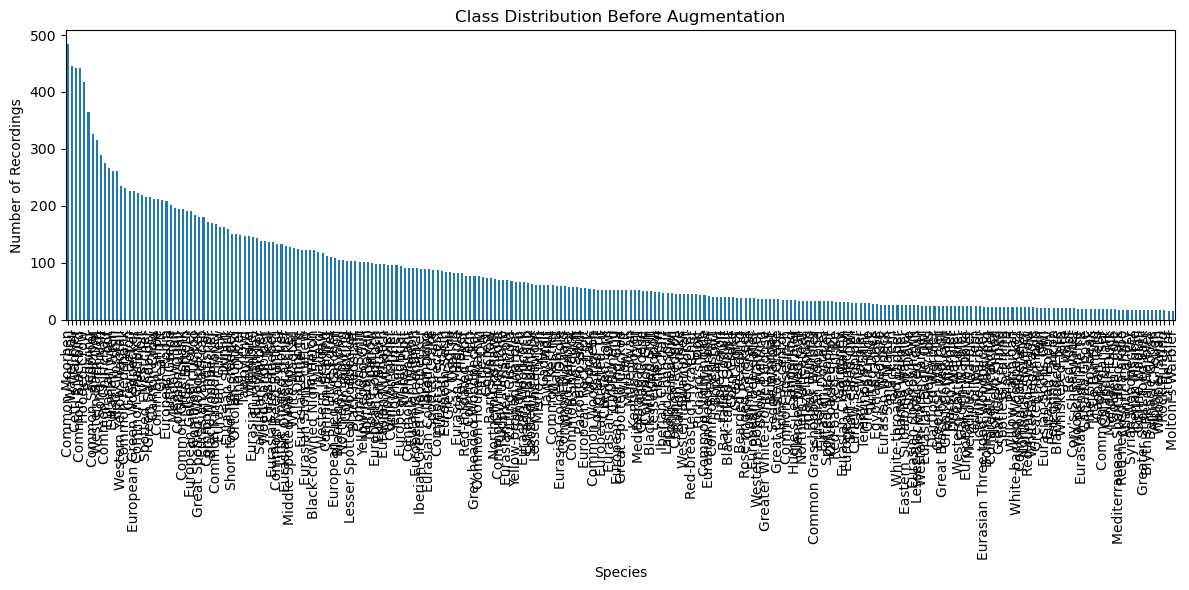

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
species_counts.plot(kind='bar')
plt.title('Class Distribution Before Augmentation')
plt.xlabel('Species')
plt.ylabel('Number of Recordings')
plt.tight_layout()
plt.show()


In [ ]:
output_feature_dir = '../data/processed/features/xeno_canto'
os.makedirs(output_feature_dir, exist_ok=True)

target_recordings = 100

augmentation_factors = {}
for species, count in species_counts.items():
    needed_augmentations = max(0, target_recordings - count)
    if count > 100:
        max_augment_per_sample = 1
    elif count > 50:
        max_augment_per_sample = 2
    elif count > 25:
        max_augment_per_sample = 5
    else:
        max_augment_per_sample = 10

    if needed_augmentations > 0:
        augmentation_per_sample = max(1, needed_augmentations // count)
        augmentation_factors[species] = min(augmentation_per_sample, max_augment_per_sample)
    else:
        augmentation_factors[species] = 0
species_counts_after_aug = {species: 0 for species in species_counts.index}

for index, row in df.iterrows():
    audio_id = row['id']
    species_name = row['en']
    audio_path_pattern = os.path.join(input_audio_dir, f"{audio_id}.*")
    audio_files = glob.glob(audio_path_pattern)

    if not audio_files:
        print(f"No audio file found for ID {audio_id}. Skipping.")
        continue
    if len(audio_files) > 1:
        print(f"Multiple audio files found for ID {audio_id}. Skipping.")
        continue

    audio_path = audio_files[0]
    try:
        # Always process the file once
        y = process_audio_file_with_denoising(audio_path)
        S_db = create_log_mel_spectrogram(y, SAMPLE_RATE)

        # Save the original spectrogram and features
        spectrogram_filename = f"{audio_id}_logmel.npy"
        spectrogram_path = os.path.join(output_spectrogram_dir, spectrogram_filename)
        save_log_mel_spectrogram(S_db, spectrogram_path)

        combined_features = create_combined_features(y, SAMPLE_RATE)
        feature_filename = f"{audio_id}_combined.npy"
        feature_path = os.path.join(output_feature_dir, feature_filename)
        save_combined_features(y, SAMPLE_RATE, feature_path)
        
        
        species_counts_after_aug[species_name] += 1

        repeat_count = augmentation_factors.get(species_name, 0)
        #print(f"Processing {audio_id} for species '{species_name}' with repeat count {repeat_count}")

        for i in range(repeat_count):
            y_aug = y.copy()

            # Apply augmentations
            if np.random.rand() < 0.3:
                y_aug = librosa.effects.pitch_shift(y_aug, sr=SAMPLE_RATE, n_steps=2)
            if np.random.rand() < 0.3:
                y_aug = librosa.effects.time_stretch(y_aug, rate=np.random.uniform(0.95, 1.05))
            if np.random.rand() < 0.3:
                y_aug = add_gaussian_noise(y_aug)

            S_db_aug = create_log_mel_spectrogram(y_aug, SAMPLE_RATE)
            S_db_augmented = apply_spectrogram_augmentation(S_db_aug.copy())

            spectrogram_filename = f"{audio_id}_aug_{i}_logmel.npy"
            spectrogram_path = os.path.join(output_spectrogram_dir, spectrogram_filename)
            save_log_mel_spectrogram(S_db_augmented, spectrogram_path)

            combined_features = create_combined_features(y_aug, SAMPLE_RATE)
            feature_filename = f"{audio_id}_aug_{i}_combined.npy"
            feature_path = os.path.join(output_feature_dir, feature_filename)
            save_combined_features(y_aug, SAMPLE_RATE, feature_path)
            species_counts_after_aug[species_name] += 1

    except Exception as e:
        print(f"Error processing {audio_id}: {e}")


print("Feature extraction, Log-Mel spectrogram generation, and augmentation complete.")

C:\Users\maiko\AppData\Roaming\Python\Python312\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Users\maiko\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1796
  warnings.warn(
C:\Users\maiko\AppData\Local\Temp\ipykernel_17896\4272807073.py:30: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=None)
C:\Users\maiko\AppData\Roaming\Python\Python312\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing 375211: 


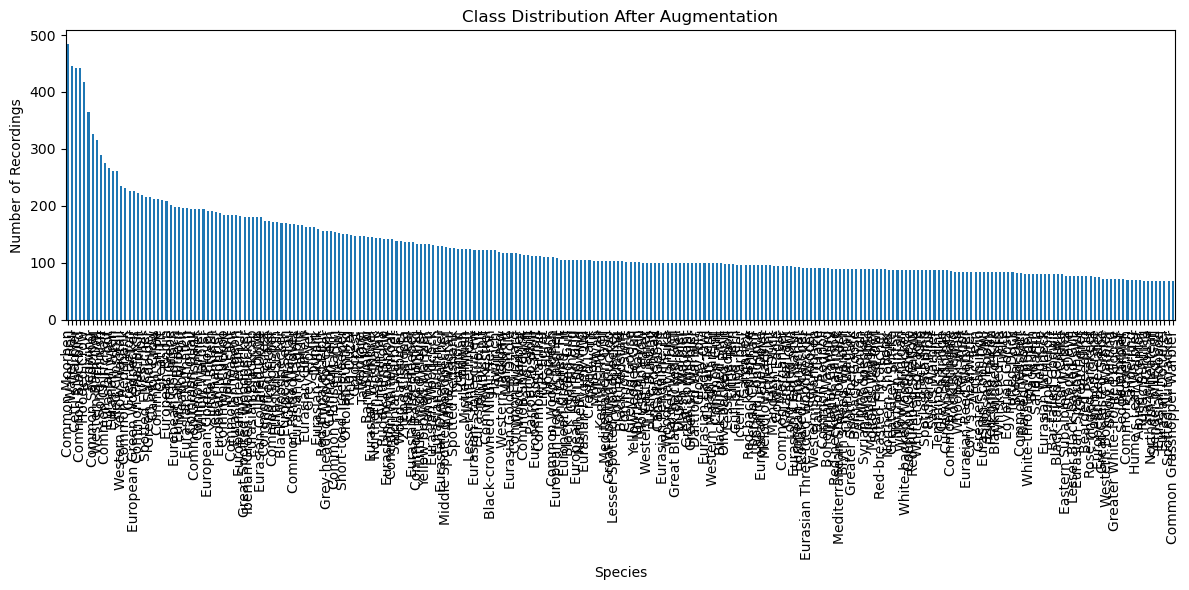

In [99]:
# Convert the counts dictionary to a pandas Series
species_counts_after_aug_series = pd.Series(species_counts_after_aug)

# Sort the Series by counts in descending order
species_counts_after_aug_series = species_counts_after_aug_series.sort_values(ascending=False)

# Plotting the class distribution after augmentation
plt.figure(figsize=(12, 6))
species_counts_after_aug_series.plot(kind='bar')
plt.title('Class Distribution After Augmentation')
plt.xlabel('Species')
plt.ylabel('Number of Recordings')
plt.tight_layout()
plt.show()


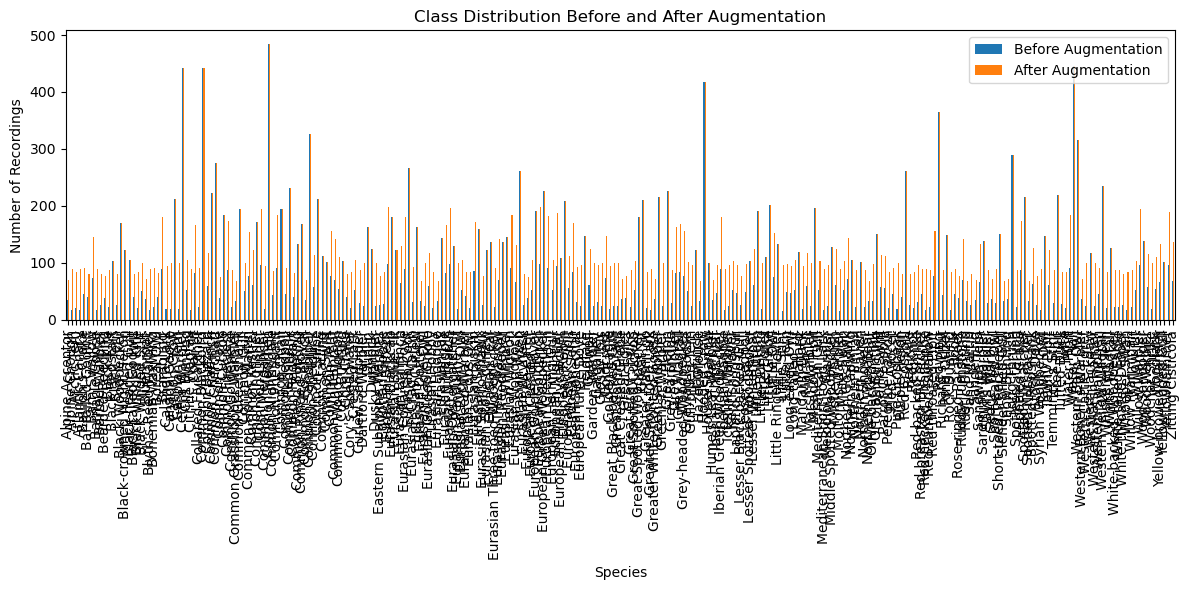

In [101]:
# Combine the counts into a DataFrame
counts_df = pd.DataFrame({
    'Before Augmentation': species_counts,
    'After Augmentation': species_counts_after_aug_series
})

# Ensure the indices align
counts_df = counts_df.fillna(0)

# Plotting the combined class distributions
counts_df.plot(kind='bar', figsize=(12, 6))
plt.title('Class Distribution Before and After Augmentation')
plt.xlabel('Species')
plt.ylabel('Number of Recordings')
plt.tight_layout()
plt.show()
